# KPP Test Problem

This notebook demonstrates how to
- Set up a scalar, nonlinear hyperbolic PDE 
- Set up an initial-boundary value problem
- Choose a particular set of numerics
- Post-process the solution

In [1]:
%matplotlib notebook
import  math
import  numpy as  np
from proteus.iproteus import * 
Profiling.logLevel=5
Profiling.verbose=True

/home/cekees/proteus/linux2/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Defining an equation
The equation we want to solve is
\begin{equation*}
m_t + \nabla \cdot \mathbf{f} = 0
\end{equation*}
where $u$ is the unknown solution and the coefficients have the specific  forms
\begin{align}
m(u) &= u \\
f(u) &= (sin(u), cos(u)) 
\end{align}

In [2]:
class KPP(TransportCoefficients.TC_base):
    """
    The coefficients of the linear advection-diffusion equation
    """
    def __init__(self):
        TransportCoefficients.TC_base.__init__(self,
                                               nc=1, #number of components
                                               variableNames=['u'],
                                               mass      = {0:{0:'linear'}},
                                               advection = {0:{0:'nonlinear'}})
                                                                                           
    def evaluate(self,t,c):
        c[('m',0)][:]         = c[('u',0)]  
        c[('dm',0,0)][:]      = 1.0
        c[('f',0)][...,0]     = np.sin(c[('u',0)])
        c[('f',0)][...,1]     = np.cos(c[('u',0)])
        c[('df',0,0)][...,0]  = np.cos(c[('u',0)])
        c[('df',0,0)][...,1]  = -np.sin(c[('u',0)])


# Physics

In [3]:
from proteus import default_p as p
#physics
p.name = "ladr_2d"
p.nd = 2; #Two dimensions
box=Domain.RectangularDomain(L=(4.0,4.0),
                             x=(-2.0,-2.5),
                             name="kpp");
box.writePoly("kpp")
p.domain=Domain.PlanarStraightLineGraphDomain(fileprefix="kpp")

p.T=1.0

p.coefficients=KPP()

def getDBC(x,flag):
    if flag in ['left','right','top','bottom']:
        return lambda x,t: math.pi/4.0
    
p.dirichletConditions = {0:getDBC}
p.advectiveFluxBoundaryConditions = {}

class IC:
    def __init__(self):
        pass
    def uOfXT(self,x,t):
        if math.sqrt(x[0]**2 + x[1]**2) <= 1.0:
            return 14.0*math.pi/4.0
        else:
            return math.pi/4.0

p.initialConditions  = {0:IC()}

# Numerics

In [4]:
from proteus import default_n as n
from proteus.Gauges  import LineGauges
import numpy as np
import proteus as pr
n.triangleOptions="VApq33Dena%8.8f" % (0.0025,)
n.timeIntegration = pr.TimeIntegration.BackwardEuler_cfl
n.stepController = pr.StepControl.Min_dt_cfl_controller
n.runCFL=0.9
n.femSpaces = {0:pr.FemTools.C0_AffineLinearOnSimplexWithNodalBasis}
n.elementQuadrature = pr.Quadrature.SimplexGaussQuadrature(p.nd,3)
n.elementBoundaryQuadrature = pr.Quadrature.SimplexGaussQuadrature(p.nd-1,3)
n.subgridError = pr.SubgridError.AdvectionLag_ASGS(p.coefficients,
                                                   p.nd,
                                                   lag=True)
n.shockCapturing = pr.ShockCapturing.ResGradQuadDelayLag_SC(p.coefficients,
                                                            p.nd,
                                                            shockCapturingFactor=0.9,
                                                            nStepsToDelay=1,
                                                            lag=False)
n.numericalFluxType = pr.NumericalFlux.Advection_DiagonalUpwind_exterior
n.tnList=[0.0,0.001]+[float(i)/10.0 for i in range(1,11)]
n.matrix = pr.LinearAlgebraTools.SparseMatrix
n.multilevelLinearSolver = pr.LinearSolvers.LU#KSP_petsc4py
n.l_atol_res = 0.0
n.linTolFac = 0.001
n.tolFac = 0.0
n.nl_atol_res = 1.0e-4
n.maxNonlinearIts =500
n.maxLineSearches =0
n.parallelPartitioningType = pr.MeshTools.MeshParallelPartitioningTypes.node
n.nLayersOfOverlapForParallel = 0
n.periodicDirichletConditions = None
lineGauges  = LineGauges(gauges=((('u',),#fields in gauge set
                                  (#lines for these fields
                                      ((-2.0, -2.5, 0.0),(2.0, 1.5, 0.0)),
                                  ),#end  lines
                              ),#end gauge set
                             ),#end gauges
                         fileName="profile.csv")
n.auxiliaryVariables=[lineGauges]

# Operator Splitting
Trivial since this is a scalar PDE

In [5]:
from proteus import default_s,default_so
so = default_so
so.name = p.name 
so.sList=[default_s]
so.tnList = n.tnList

# Initialize Numerical Solution Object

In [6]:
ns = NumericalSolution.NS_base(so,[p],[n],so.sList,opts)

/home/cekees/proteus/proteus/TriangleTools.py:599: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if nodesM == None:
/home/cekees/proteus/proteus/TriangleTools.py:609: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if segmentsM == None:
/home/cekees/proteus/proteus/TriangleTools.py:617: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (not regions == None):
/home/cekees/proteus/proteus/TriangleUtils.py:92: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if nodes == None: #ok to do nothing of nodes is empy


[       0] Initializing NumericalSolution for ladr_2d
 System includes: 
ladr_2d

[       0] Setting Archiver(s)
[       0] Setting up MultilevelMesh
[       0] Building one multilevel mesh for all models
[       0] Generating mesh for ladr_2d
[       0] Calling Triangle to generate 2D mesh forladr_2d
TriangleBaseMesh nbase=1 baseFlags= VApq33Dena0.00250000 


/home/cekees/proteus/proteus/TriangleUtils.py:116: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if markers != None:
/home/cekees/proteus/proteus/TriangleUtils.py:146: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if elems == None: #ok to do nothing of nodes is empy
/home/cekees/proteus/proteus/TriangleUtils.py:167: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if attrib != None:
/home/cekees/proteus/proteus/TriangleUtils.py:206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if nodes == None: #ok to do nothing of nodes is empy
/home/cekees/proteus/proteus/TriangleUtils.py:208: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if segments == None:
/home/cekees/proteus/proteus/TriangleUtils.py:244: FutureWarning: comparis

[       0] Converting to Proteus Mesh
[       0] Generating 1-level mesh from coarse Triangle mesh
[       0] Partitioning mesh among 1 processors using partitioningType = 1
[       0] Number of Subdomain Elements Owned= 10926
[       0] Number of Subdomain Elements = 10926
[       0] Number of Subdomain Nodes Owned= 5594
[       0] Number of Subdomain Nodes = 5594
[       0] Number of Subdomain elementBoundaries Owned= 16519
[       0] Number of Subdomain elementBoundaries = 16519
[       0] Number of Subdomain Edges Owned= 16519
[       0] Number of Subdomain Edges = 16519
[       0] Finished partitioning
[       0] *** Global ***
Number of triangles  : 10926
Number of edges : 16519
Number of nodes : 5594

*** Local ***
Number of triangles  : 10926
Number of edges : 16519
Number of nodes : 5594

[       0] Setting up MultilevelTransport for ladr_2d
[       0] Building Transport for each mesh
[       0] Generating Trial Space
[       0] Generating Test Space
[       0] Allocating u
[ 

/home/cekees/proteus/proteus/NonlinearSolvers.py:72: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if du == None:


[       2] Gauge for u[0] at -2.000000e+00 -2.500000e+00 0.000000e+00 is closest to node 0
[       2] Gauge for u[1] at -1.956356e+00 -2.456356e+00 0.000000e+00 is closest to node 2551
[       2] Gauge for u[2] at -1.924952e+00 -2.424952e+00 0.000000e+00 is closest to node 2492
[       2] Gauge for u[3] at -1.896465e+00 -2.396465e+00 0.000000e+00 is closest to node 2484
[       2] Gauge for u[4] at -1.891746e+00 -2.391746e+00 0.000000e+00 is closest to node 2484
[       2] Gauge for u[5] at -1.888252e+00 -2.388252e+00 0.000000e+00 is closest to node 2484
[       2] Gauge for u[6] at -1.868366e+00 -2.368366e+00 0.000000e+00 is closest to node 2487
[       2] Gauge for u[7] at -1.839343e+00 -2.339343e+00 0.000000e+00 is closest to node 2471
[       2] Gauge for u[8] at -1.834417e+00 -2.334417e+00 0.000000e+00 is closest to node 2471
[       2] Gauge for u[9] at -1.819846e+00 -2.319846e+00 0.000000e+00 is closest to node 2476
[       2] Gauge for u[10] at -1.808289e+00 -2.308289e+00 0.000

<IPython.core.display.Javascript object>


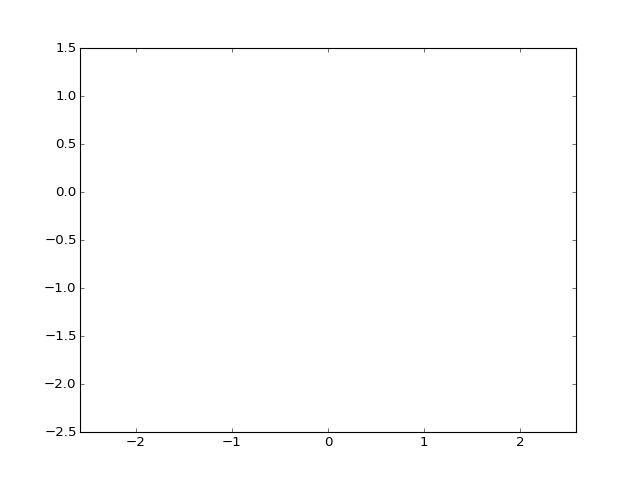

/home/cekees/proteus/linux2/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


<matplotlib.tri.tricontour.TriContourSet instance at 0x7f0d67f694d0>

In [7]:
from matplotlib import pyplot as plt
fig = plt.figure()
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
u = ns.modelList[0].levelModelList[-1].u[0].dof
plt.axis('equal')
plt.tricontour(x,y,triangles,u,np.linspace(math.pi/4.0,14.0*math.pi/4.0),colors='k')

# Calculate Solution

In [8]:
failed = ns.calculateSolution('ladr_run1')
assert(not failed)

[       2] Setting initial conditions
[       2] Setting initial conditions for ladr_2d
[       2] Setting initial conditions on model ladr_2d
[       2] Attaching models and running spin-up step if requested
[       2] Attaching models to model ladr_2d
[       2] Archiving initial conditions
[       2] Writing initial mesh for  model = ladr_2d
[       2] Writing initial conditions for  model = ladr_2d
[       2] Syncing Archive
[       2] Gathering Archive Time step
[       2] Done Gathering Archive Time Step
[       2] Done Syncing Archive
[       2] Estimating initial time derivative and initializing time history for model ladr_2d
[       2] Choosing initial time step for model ladr_2d
[       2] Initializing time step on model ladr_2d to dt =  2.54425e-02
[       2] Initializing time history for model step controller
[       2] Initializing time step on system Default System to dt =  2.54425e-02
[       2] Initializing step sequence for system Default System to [(0.0254424600809827

/home/cekees/proteus/proteus/NonlinearSolvers.py:170: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if r == None:
/home/cekees/proteus/proteus/LinearSolvers.py:102: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if b == None:
/home/cekees/proteus/proteus/LinearSolvers.py:97: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.r == None:


[       2]    Newton it 1 norm(r) =  4.30307e+00  		 norm(r)/(rtol*norm(r0)+atol) = 43030.7 test=r
[       3]    Newton it 2 norm(r) =  1.70496e+00  		 norm(r)/(rtol*norm(r0)+atol) = 17049.6 test=r
[       3]    Newton it 3 norm(r) =  8.83831e-01  		 norm(r)/(rtol*norm(r0)+atol) = 8838.31 test=r
[       3]    Newton it 4 norm(r) =  4.28961e-01  		 norm(r)/(rtol*norm(r0)+atol) = 4289.61 test=r
[       3]    Newton it 5 norm(r) =  2.08895e-01  		 norm(r)/(rtol*norm(r0)+atol) = 2088.95 test=r
[       3]    Newton it 6 norm(r) =  1.03233e-01  		 norm(r)/(rtol*norm(r0)+atol) = 1032.33 test=r
[       3]    Newton it 7 norm(r) =  5.52510e-02  		 norm(r)/(rtol*norm(r0)+atol) = 552.51 test=r
[       3]    Newton it 8 norm(r) =  3.24350e-02  		 norm(r)/(rtol*norm(r0)+atol) = 324.35 test=r
[       3]    Newton it 9 norm(r) =  2.04596e-02  		 norm(r)/(rtol*norm(r0)+atol) = 204.596 test=r
[       3]    Newton it 10 norm(r) =  1.33907e-02  		 norm(r)/(rtol*norm(r0)+atol) = 133.907 test=r
[       3] 

<IPython.core.display.Javascript object>


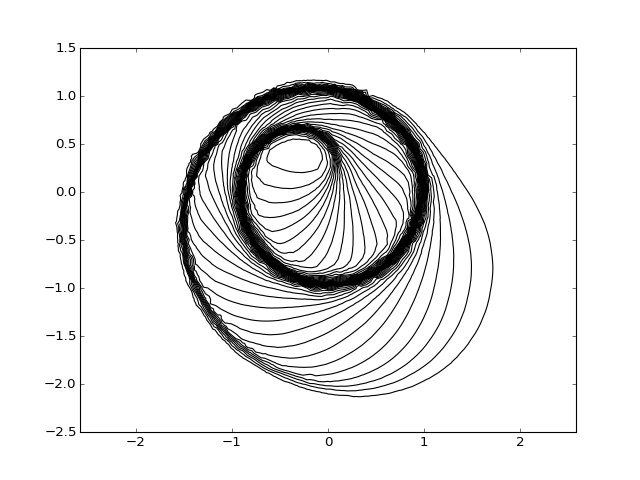

<matplotlib.tri.tricontour.TriContourSet instance at 0x7f0d5501def0>

In [9]:
from matplotlib import pyplot as plt
fig = plt.figure()
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
u = ns.modelList[0].levelModelList[-1].u[0].dof
plt.axis('equal')
plt.tricontour(x,y,triangles,u,np.linspace(math.pi/4.0,14.0*math.pi/4.0,51)[1:],colors='k')

<IPython.core.display.Javascript object>


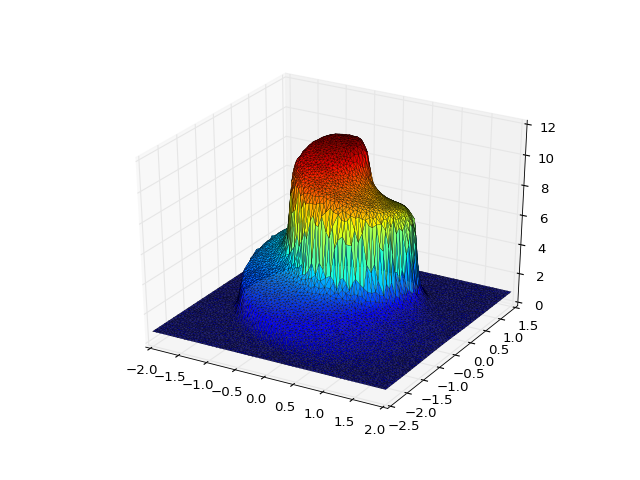

/home/cekees/proteus/linux2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib  import pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')

x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
u = ns.modelList[0].levelModelList[-1].u[0].dof
ax.plot_trisurf(x,y,u,cmap=cm.jet, linewidth=0.2)

<IPython.core.display.Javascript object>


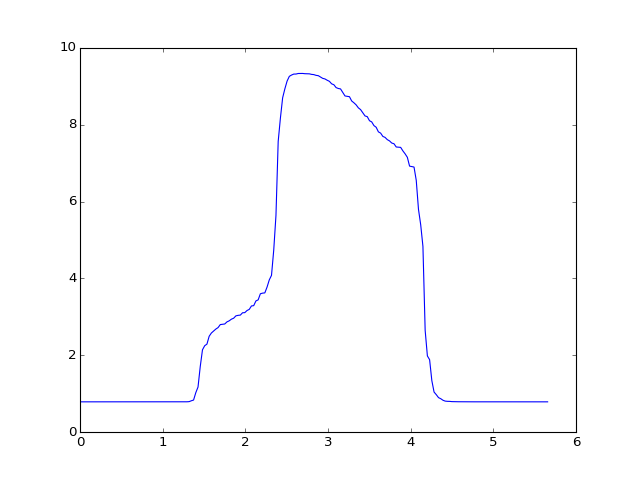

In [11]:
column = np.loadtxt("profile.csv",skiprows=1,delimiter=",")
z = np.linspace(0.0,math.sqrt(2.0)*4.0,column[-1,1:].shape[0])
fig = plt.figure()
plt.plot(z,column[-1,1:])